<a href="https://colab.research.google.com/github/the-pinbo/image-denoising/blob/main/model_with_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration without Denoised
##Mini Project in Image Processing
##EC386
###Members


1.   
```
Inbasekaran Perumal
201EC226
inba2002.p@gmail.com
```
2.   
```
Pranav Koundinya
201EC241
pranavmkoundinya@gmail.com
```

###Guide
```
Prof. Sumam David S
```


###Course Instructor
```
Prof. Deepu Vijayasenan
```

In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Tensor flow gpu check
import tensorflow as tf
tf.test.gpu_device_name()

''

To format the code do this 
```
!pip install black[jupyter]
!/content/drive/MyDrive/ImageProcessing/model.ipynb
```



In [ ]:
#@title Importing Modules
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
import math
import time 
import pathlib
from sklearn.model_selection import train_test_split
tf.random.set_seed(0)

In [ ]:
#@title Helper functions to navigate directories 

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Made dir: ", path)
    else:
        print(f" {path} already exists")

def get_pwd():
    return os.getcwd()

def change_dir(path):
    os.chdir(path)
    print(f"Changed directory to {get_pwd()}")
    

def list_dir(path):
    return os.listdir(path)

In [ ]:
#@title Define data root directory
data_root = "/content/drive/MyDrive/ImageProcessing/" #@param ["/content/drive/MyDrive/ImageProcessing/"] {allow-input: true}
change_dir(data_root)

Changed directory to /content/drive/MyDrive/ImageProcessing


In [ ]:
#@title Define constant width and height
width = 256 #@param {type:"number"}
height = 256 #@param {type:"number"}

In [ ]:
#@title mean and var
mean = 0 #@param {type:"number"}
var = .01 #@param {type:"number"}

In [ ]:
#@title Download flickr8k dataset 
control = "no" #@param ["yes", "no"]
name = "flickr8k" #@param ["flickr8k"]
download_dir = data_root + "/dataset" + "/" + name
origin_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" #@param ["https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"] {allow-input: true}
if control == "yes":
    data_root_orig = tf.keras.utils.get_file(
        origin=origin_url,
        cache_dir='.',
        cache_subdir=download_dir,
        extract=True)
    print(f"Downloaded successfully in {data_root_orig}")


1115419746/1115419746 [==============================] - 23s 0us/step


In [ ]:
#@title Preprocessing helper functions 
def normalize_scan(image):
    norm_image = cv2.normalize(
        image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
    )
    return norm_image

def resize_scan(scan, desired_width, desired_height):
    scan = cv2.resize(scan, (desired_height, desired_width))
    return scan

def preprocess_scan(path, width, height):
    scan = cv2.imread(path)
    resized_scan = resize_scan(scan, width, height)
    normalized_resized_scan = normalize_scan(resized_scan)
    return normalized_resized_scan

def generate_img(image):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
#@title Noise helper functions 
def addGaussNoise(image,mean=0,var=.01):
    row, col, ch = image.shape
    sigma = var**0.5
    np.random.seed(int(time.time()))
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return noisy

In [ ]:
#@title Define noise dir and clean img dir
clean_img_dir = "/content/drive/MyDrive/ImageProcessing/dataset/flickr8k/Flicker8k_Dataset" #@param ["/content/drive/MyDrive/ImageProcessing/dataset/flickr8k/Flicker8k_Dataset"] {allow-input: true}
noise_dir = "/content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise" #@param ["/content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise"] {allow-input: true}
make_dir(noise_dir)
noise_dir = noise_dir + f"/m_{mean}__v_{var}".replace(".","d")
make_dir(noise_dir)
noise_1_dir = noise_dir + "/noise_1"
make_dir(noise_1_dir)
noise_2_dir = noise_dir + "/noise_2"
make_dir(noise_2_dir)

Made dir:  /content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise
Made dir:  /content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise/m_0__v_0d01
Made dir:  /content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise/m_0__v_0d01/noise_1
Made dir:  /content/drive/MyDrive/ImageProcessing/dataset/flickr8k/noise/m_0__v_0d01/noise_2


In [ ]:
#@title Define function to preprocess and save 
def preprocess_images(clean_img_dir,noise_1_dir,noise_2_dir):
    clean_img_paths = pathlib.Path(clean_img_dir).glob("*." + ext)
    image_count = len(list(clean_img_paths))
    print(f"Preprocessing {image_count} images")
    clean_img_paths = pathlib.Path(clean_img_dir).glob("*." + ext)
    for img_path in tqdm(clean_img_paths, total=image_count):
        img = preprocess_scan(str(img_path), width, height)
        n_img_1 = addGaussNoise(img, mean, var)
        n_img_2 = addGaussNoise(img, mean, var)
        img_name = str(img_path).split('/')[-1]
        # print(img_name)
        cv2.imwrite(noise_1_dir + "/" + img_name, n_img_1*255)
        cv2.imwrite(noise_2_dir + "/" + img_name, n_img_2*255)

In [ ]:
#@title Pre-Process the train images 
ext = "jpg" #@param ["jpg", "png"] {allow-input: true}
# preprocess and store images in their dir 
control = "yes" #@param ["yes", "no"]
if control == 'yes':
    preprocess_images(clean_img_dir,noise_1_dir,noise_2_dir)


Preprocessing 8091 images


100%|██████████| 8091/8091 [08:50<00:00, 15.25it/s]


In [ ]:
#@title Helper functions to plot original noise1 and noise2 images 

def plot3(img_path, n_img_1_path, n_img_2_path):
    plt.figure(figsize=(15, 15))
    # plot clean image 
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    # plot noise 1
    plt.subplot(1, 3, 2)
    plt.title("Noisy Image 1")
    plt.imshow(cv2.cvtColor(cv2.imread(n_img_1_path), cv2.COLOR_BGR2RGB))
    # plot noise 2
    plt.subplot(1, 3, 3)
    plt.title("Noisy Image 2")
    plt.imshow(cv2.cvtColor(cv2.imread(n_img_2_path), cv2.COLOR_BGR2RGB))
    plt.show()


def plot_first_n(n):
    clean_img_paths = pathlib.Path(clean_img_dir).glob("*." + ext)
    for _ in range(n):
        img_path = next(clean_img_paths)
        img_name = str(img_path).split('/')[-1]
        n_img_1 = noise_1_dir + "/" + img_name
        n_img_2 = noise_2_dir + "/" + img_name
        plot3(str(img_path),n_img_1,n_img_2)

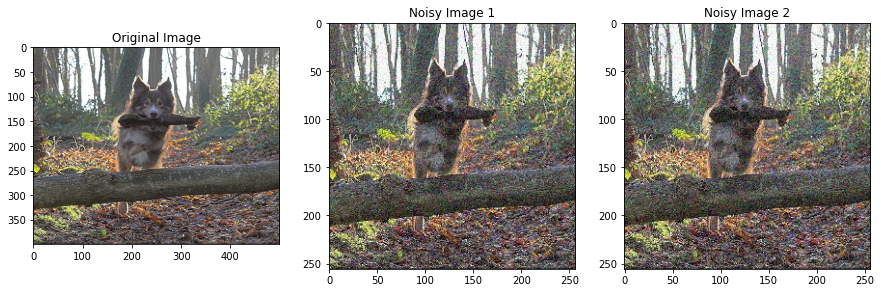

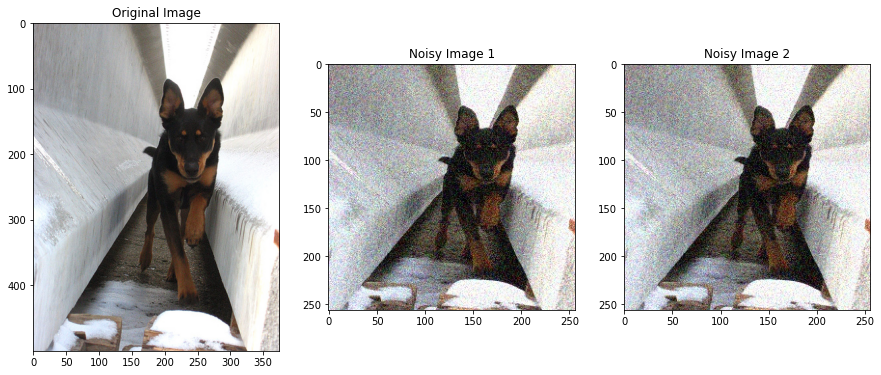

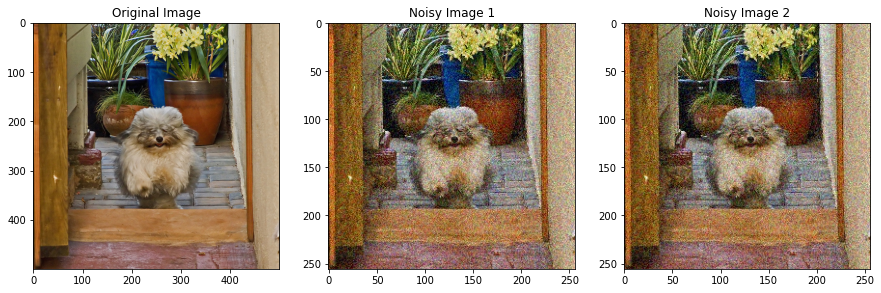

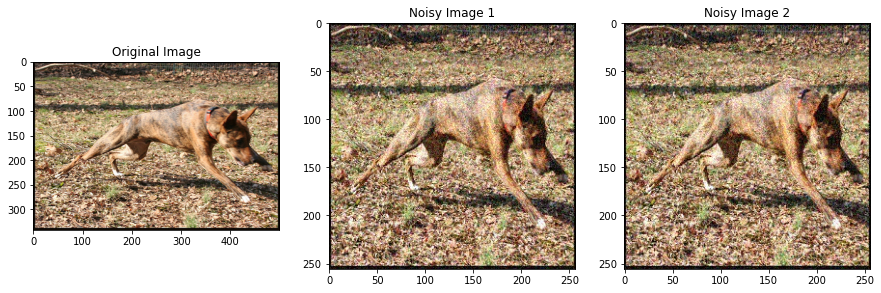

In [ ]:
#@title Plot first n images original, noise 1 , noise 2
n = 4 #@param {type:"slider", min:1, max:15, step:1}
plot_first_n(n)

In [ ]:
#@title Create File DataFrame 
noise_1_paths = pd.Series(list(pathlib.Path(noise_1_dir).glob("*." + ext)), name='noise_1').astype(str)
noise_2_paths = pd.Series(list(pathlib.Path(noise_2_dir).glob("*." + ext)), name='noise_2').astype(str)

In [ ]:
noise_1_paths.describe()

count                                                  8091
unique                                                 8091
top       /content/drive/MyDrive/ImageProcessing/dataset...
freq                                                      1
Name: noise_1, dtype: object

In [ ]:
noise_2_paths.describe()

count                                                  8091
unique                                                 8091
top       /content/drive/MyDrive/ImageProcessing/dataset...
freq                                                      1
Name: noise_2, dtype: object

In [ ]:
images_df = pd.concat([noise_1_paths, noise_2_paths], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images_df.describe()

,noise_1,noise_2
count,8091,8091
unique,8091,8091
top,/content/drive/MyDrive/ImageProcessing/dataset...,/content/drive/MyDrive/ImageProcessing/dataset...
freq,1,1


In [ ]:
train_size = 0.75 #@param {type:"slider", min:0, max:1, step:0.01}
train_df, test_df = train_test_split(images_df, train_size=train_size, shuffle=True, random_state=1)

In [ ]:
train_df.describe()

,noise_1,noise_2
count,6068,6068
unique,6068,6068
top,/content/drive/MyDrive/ImageProcessing/dataset...,/content/drive/MyDrive/ImageProcessing/dataset...
freq,1,1


In [ ]:
test_df.describe()

,noise_1,noise_2
count,2023,2023
unique,2023,2023
top,/content/drive/MyDrive/ImageProcessing/dataset...,/content/drive/MyDrive/ImageProcessing/dataset...
freq,1,1


In [ ]:
#@title Defining batch size 
# Batch size
BATCH_SIZE = 128

In [ ]:
#@title Defining our custom data generator 

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size=BATCH_SIZE,
                 input_size=(height,width,3),
                 shuffle=True):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, noise_1):
    
        image = tf.keras.preprocessing.image.load_img(noise_1)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        return image_arr/255.
    
    def __get_output(self, noise_2):
        image = tf.keras.preprocessing.image.load_img(noise_2)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        return image_arr/255.
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        noise_1_batch = batches["noise_1"]
        x_batch = np.asarray([self.__get_input(noise_1) for  noise_1 in noise_1_batch])

        noise_2_batch = batches["noise_2"]
        y_batch = np.asarray([self.__get_output(noise_2) for  noise_2 in noise_2_batch])

        return x_batch,y_batch
    
    def __getitem__(self, index):
        # X will be a NumPy array of shape (batch_size, input_height, input_width, input_channel)
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
traingen = CustomDataGen(train_df)
print(f"Number of train batches {len(traingen)}")

Number of train batches 47


In [ ]:
valgen = CustomDataGen(test_df)
print(f"Number of validation batches {len(valgen)}")

Number of validation batches 15


In [ ]:
#@title Importing modules for training 
from tensorflow.keras.losses import MeanSquaredError
mse = tf.keras.losses.MeanSquaredError()
# mse(train_gaussian_noise_images[0], train_scans[0]).numpy()
from keras import Input, Model, Sequential
from keras import layers
from keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers.experimental.preprocessing import (
    RandomFlip,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
K.clear_session()

In [ ]:
#@title Data augmentation
data_augmentation = Sequential(
    [RandomFlip(mode="horizontal", seed=0), RandomContrast(0.1, seed=0)]
)

In [ ]:
#@title Load a model if saved 
print("Do you want to load an existing model[yes/no]?")
opt = "no" #@param ["yes", "no"]
fileName = "/content/drive/MyDrive/ImageProcessing/dataset/models/baseline.h" #@param ["/content/drive/MyDrive/ImageProcessing/dataset/models/baseline.h"] {allow-input: true}
if opt == "yes":
    from keras import models
    model = models.load_model(fileName)
    print(model.summary())
    # print(model.get_weights())    
    # print(model.opttimizer())  


Do you want to load an existing model[yes/no]?


In [ ]:
#@title U-Net model
def UNet():

    input_img = Input(shape=(256, 256, 3))
    augmentation = data_augmentation(input_img)

    # ============================================================================
    # == ENCODER
    # ============================================================================

    conv_1_a = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(augmentation)
    l_relu_1_a = layers.LeakyReLU()(conv_1_a)
    conv_1_b = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(l_relu_1_a)
    l_relu_1_b = layers.LeakyReLU()(conv_1_b)
    maxpool_1 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_1_b)
    print(maxpool_1.shape)

    conv_2 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_1)
    l_relu_2 = layers.LeakyReLU()(conv_2)
    maxpool_2 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_2)
    print(maxpool_2.shape)

    conv_3 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_2)
    l_relu_3 = layers.LeakyReLU()(conv_3)
    maxpool_3 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_3)
    print(maxpool_3.shape)

    conv_4 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_3)
    l_relu_4 = layers.LeakyReLU()(conv_4)
    maxpool_4 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_4)
    print(maxpool_4.shape)

    conv_5_a = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_4)
    l_relu_5_a = layers.LeakyReLU()(conv_5_a)
    maxpool_5 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_5_a)
    print(maxpool_5.shape)

    conv_5_b = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_5)
    encoded = layers.LeakyReLU()(conv_5_b)

    # ============================================================================
    # == DECODER
    # ============================================================================

    upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
    print(upsamp_6.shape)
    concat_6 = tf.concat([upsamp_6, maxpool_4], axis=3)
    print(concat_6.shape)
    conv_6_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_6)
    l_relu_6_a = layers.LeakyReLU()(conv_6_a)
    conv_6_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_6_a)
    l_relu_6_b = layers.LeakyReLU()(conv_6_b)

    upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
    print(upsamp_7.shape)
    concat_7 = tf.concat([upsamp_7, maxpool_3], axis=3)
    print(concat_7.shape)
    conv_7_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_7)
    l_relu_7_a = layers.LeakyReLU()(conv_7_a)
    conv_7_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_7_a)
    l_relu_7_b = layers.LeakyReLU()(conv_7_b)

    upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
    print(upsamp_8.shape)
    concat_8 = tf.concat([upsamp_8, maxpool_2], axis=3)
    print(concat_8.shape)
    conv_8_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_8)
    l_relu_8_a = layers.LeakyReLU()(conv_8_a)
    conv_8_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_8_a)
    l_relu_8_b = layers.LeakyReLU()(conv_8_b)

    upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
    print(upsamp_9.shape)
    concat_9 = tf.concat([upsamp_9, maxpool_1], axis=3)
    print(concat_9.shape)
    conv_9_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_9)
    l_relu_9_a = layers.LeakyReLU()(conv_9_a)
    conv_9_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_9_a)
    l_relu_9_b = layers.LeakyReLU()(conv_9_b)

    upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
    print(upsamp_10.shape)
    concat_10 = tf.concat([upsamp_10, input_img], axis=3)
    print(concat_10.shape)
    conv_10_a = layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(concat_10)
    l_relu_10_a = layers.LeakyReLU()(conv_10_a)
    conv_10_b = layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(l_relu_10_a)
    l_relu_10_b = layers.LeakyReLU()(conv_10_b)

    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(
        l_relu_10_b
    )
    print(decoded.shape)

    return Model(input_img, decoded)

In [ ]:
#@title Red-Net model
def RedNet():
    il = Input(shape=(256, 256, 3))
    augmentation = data_augmentation(il)

    # ============================================================================
    # == ENCODER
    # ============================================================================

    l1 = Conv2D(
        16,
        (3, 3),
        padding="same",
        activation="relu",
    )(augmentation)
    l2 = Conv2D(16, (3, 3), padding="same", activation="relu")(l1)
    l3 = Conv2D(16, (3, 3), padding="same", activation="relu")(l2)
    l4 = Conv2D(16, (3, 3), padding="same", activation="relu")(l3)
    l5 = Conv2D(16, (3, 3), padding="same", activation="relu")(l4)

    # ============================================================================
    # == DECODER
    # ============================================================================

    l6 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(l5)
    s1 = Add()([l6, l4])
    l7 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s1)
    s2 = Add()([l7, l3])
    l8 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s2)
    s3 = Add()([l8, l2])
    l9 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s3)
    s4 = Add()([l9, l1])
    l10 = Conv2DTranspose(3, (3, 3), padding="same", activation="relu")(s4)

    model = Model(il, l10)
    return model

In [ ]:
#@title instantiation of model
architecture = "RedNet" #@param ["RedNet", "UNet"]
autoencoder = eval(architecture)()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['sequential[0][0]']             
                                )                                                                 
                                                                                              

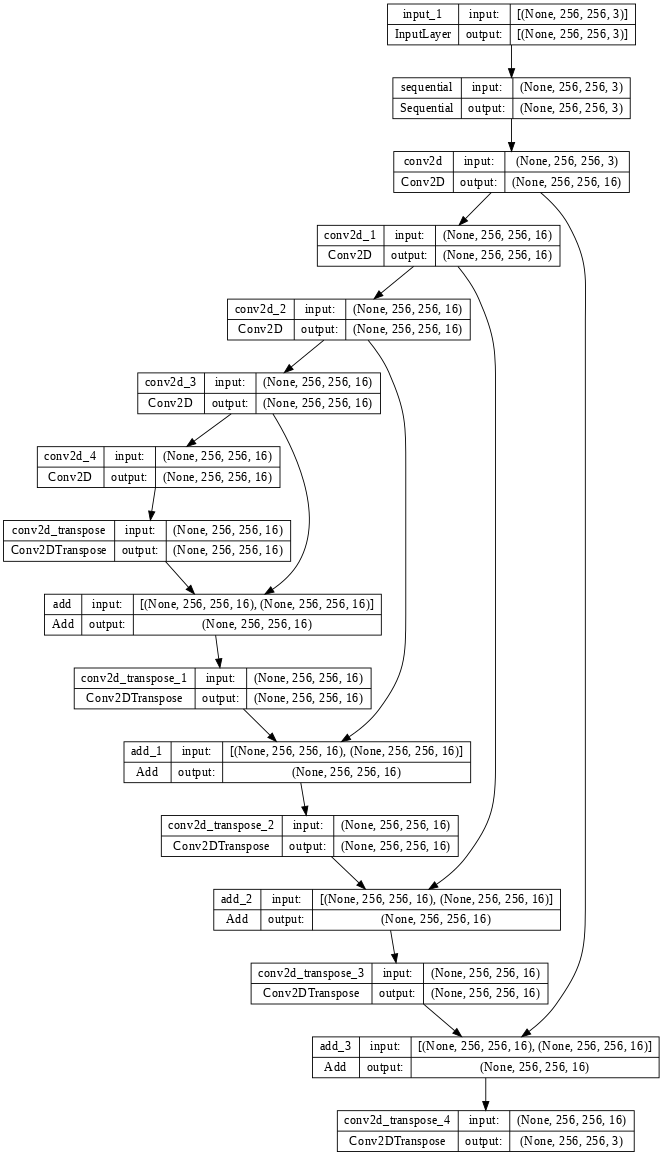

In [ ]:
#@title Plot model
from tensorflow.keras.utils import plot_model
autoencoder.summary()
plot_model(autoencoder, show_shapes=True, dpi=64)

In [ ]:
#@title Defining optimizers
from tensorflow.keras.optimizers import Adam

autoencoder_optimizer = Adam(0.0001, beta_1=0.9)
autoencoder.compile(optimizer="adam", loss=MeanSquaredError(), metrics=["accuracy"])

In [ ]:
#@title Model Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

version = "1" #@param {type:"string"}

checkpoint_path = "my_model/gauss" + f"/m_{mean}__v_{var}".replace(".","d") + f"_version_{version}"
monitor = "val_accuracy"
mode = "max"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode=mode,
)

In [ ]:
#@title Train the model 
EPOCHS = 40
history = autoencoder.fit(traingen,
            validation_data=valgen,
            epochs=EPOCHS,
            shuffle=True,
            callbacks=[model_checkpoint])

Epoch 1/40


 5/47 [==>...........................] - ETA: 48:00 - loss: 0.1781 - accuracy: 0.2544

In [ ]:
#@title Helper function to show results 
def show_results(log):
    val_loss = log.history["val_loss"]
    val_acc = log.history["val_accuracy"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    ax1, ax2 = axes
    ax1.plot(log.history["loss"], label="train")
    ax1.plot(val_loss, label="test")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.plot(log.history["accuracy"], label="train")
    ax2.plot(val_acc, label="test")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    for ax in axes:
        ax.legend()

In [ ]:
#@title Show results 
show_results(history)

In [ ]:
#@title Generate Images 
def generate_images(model, test_input, tar):
    prediction = model.predict(test_input.reshape(-1, 256, 256, 3))
    plt.figure(figsize=(15, 15))

    display_list = [
        test_input.astype("float32"),
        tar.astype("float32"),
        prediction.reshape(256, 256, 3),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])

        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))


    plt.show()

In [ ]:
#@title Visualize predictions
# for inp, tar in zip(test_gaussian_noise_images[:5], test_target_images[:5]):
#     generate_images(autoencoder, inp, tar)

for inp, tar in zip(test_gaussian_noise_images1[:5], test_gaussian_noise_images2[:5]):
    generate_images(autoencoder, inp, tar)

In [ ]:
#@title PSNR helper functions 
from math import log10, sqrt


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


def plot_comparison(input_image, target_image, prediction):
    plt.figure(figsize=(15, 15))

    display_list = [
        input_image.astype("float32"),
        target_image.astype("float32"),
        prediction.astype("float32"),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    plt.show()



In [ ]:
#@title SSIM Helper Functions
def SSIM(original, compressed):
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2
    mu_x = np.mean(original)
    mu_y = np.mean(compressed)
    sigma_x = (np.var(original))**0.5
    sigma_y = (np.var(compressed))**0.5
    covar = np.mean(original * compressed) - mu_x*mu_y
    ssim = ((2*mu_x*mu_y + c1)*(2*covar + c2)) /((mu_x**2 + mu_y**2 + c1)*(sigma_x**2 + sigma_y**2 + c2)) 
    return ssim

In [ ]:
list_ssim = []

for inp, tar in zip(test_gaussian_noise_images, clean_images_test):
    prediction = autoencoder.predict(inp.reshape(-1, 256, 256, 3))
    prediction = prediction.reshape(256, 256, 3)
    list_ssim.append(SSIM(tar, prediction))

ssim_arr = np.array(list_ssim)
mean_ssim = ssim_arr.mean()

In [ ]:
#@title Find mean PSNR

list_test_predictions = []
list_PSNR = []
for inp, tar in zip(test_gaussian_noise_images, test_target_images):
    prediction = autoencoder.predict(inp.reshape(-1, 256, 256, 3))
    prediction = prediction.reshape(256, 256, 3)
    list_test_predictions.append(prediction)
    list_PSNR.append(PSNR(tar, prediction))
np.array([100 - x for x in list_PSNR]).mean()

In [ ]:
#@title Plot top 5 results
for index in np.array(list_PSNR).argsort()[-5:]:
    plot_comparison(
        test_gaussian_noise_images[index],
        test_target_images[index],
        list_test_predictions[index],
    )

In [ ]:
#@title Save model
opt = "yes" #@param ["yes", "no"]
name = "baseline_flickr8k" #@param [""] {allow-input: true}
!mkdir models
opt = input("Do you want to save the model[yes/no]?")
if opt == "yes":
    fileName = "models/" + name +".h"
    if os.path.isfile(fileName) is False:
        autoencoder.save(fileName)

In [ ]:
#@title Save tf lite 
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)
